In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [29]:
dataset = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = dataset.load_data(num_words = 10000)

In [30]:
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequences in enumerate(sequences):
        results[i, sequences] = 1.
    return results

x_train = vectorize(train_data)
x_test = vectorize(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')



x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]


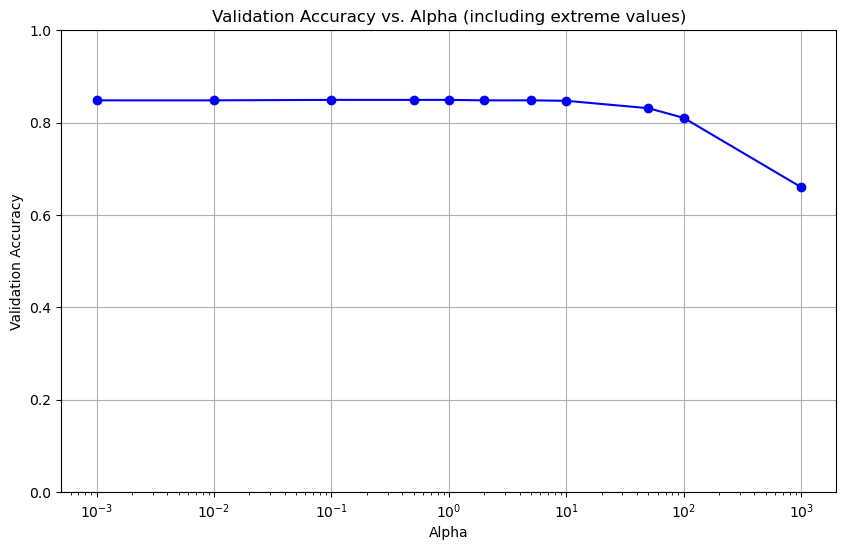

Alpha: 0.001, Validation Accuracy: 0.848
Alpha: 0.01, Validation Accuracy: 0.848
Alpha: 0.1, Validation Accuracy: 0.849
Alpha: 0.5, Validation Accuracy: 0.849
Alpha: 1.0, Validation Accuracy: 0.849
Alpha: 2.0, Validation Accuracy: 0.848
Alpha: 5.0, Validation Accuracy: 0.848
Alpha: 10.0, Validation Accuracy: 0.847
Alpha: 50.0, Validation Accuracy: 0.831
Alpha: 100.0, Validation Accuracy: 0.81
Alpha: 1000.0, Validation Accuracy: 0.66


In [46]:
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0, 1000.0]
alpha_results = []

# Evaluate model performance for each alpha value
for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier.fit(partial_x_train, partial_y_train)
    predictions = nb_classifier.predict(x_val)
    accuracy = accuracy_score(y_val, predictions)
    alpha_results.append((alpha, round(accuracy, 3)))

# Plot the results for alpha tuning
alphas, alpha_accuracies = zip(*alpha_results)
plt.figure(figsize=(10, 6))
plt.plot(alphas, alpha_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Alpha (including extreme values)')
plt.xscale('log')  # Use logarithmic scale for better visualization of wide range
plt.ylim(0, 1)
plt.grid(True)
plt.show()

for alpha, accuracy in alpha_results:
    print(f"Alpha: {alpha}, Validation Accuracy: {accuracy}")

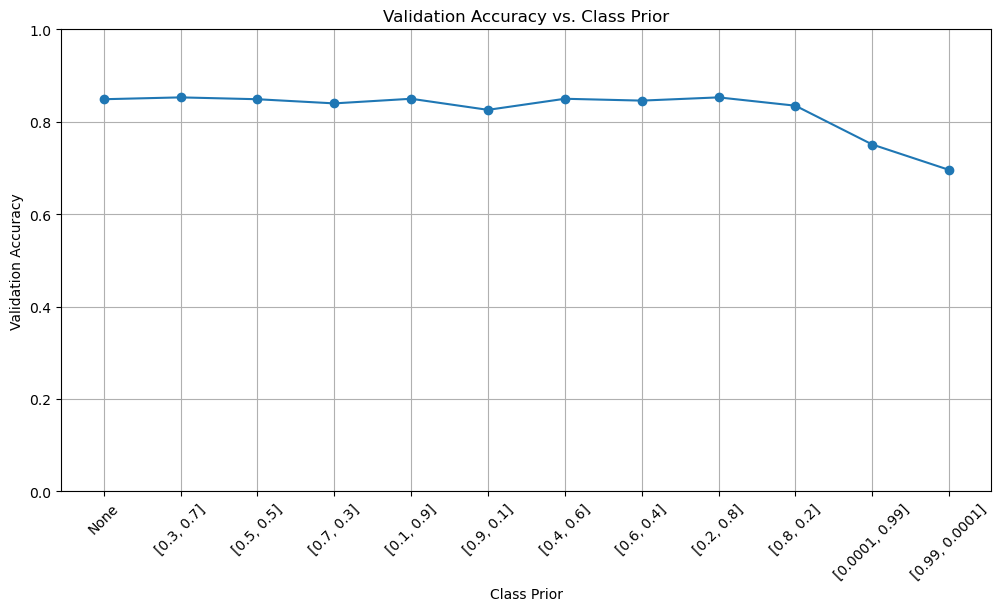

Class Prior: None, Validation Accuracy: 0.849
Class Prior: [0.3, 0.7], Validation Accuracy: 0.853
Class Prior: [0.5, 0.5], Validation Accuracy: 0.849
Class Prior: [0.7, 0.3], Validation Accuracy: 0.84
Class Prior: [0.1, 0.9], Validation Accuracy: 0.85
Class Prior: [0.9, 0.1], Validation Accuracy: 0.826
Class Prior: [0.4, 0.6], Validation Accuracy: 0.85
Class Prior: [0.6, 0.4], Validation Accuracy: 0.846
Class Prior: [0.2, 0.8], Validation Accuracy: 0.853
Class Prior: [0.8, 0.2], Validation Accuracy: 0.835
Class Prior: [0.0001, 0.99], Validation Accuracy: 0.751
Class Prior: [0.99, 0.0001], Validation Accuracy: 0.696


In [63]:
class_prior_options = [None, [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.1, 0.9], [0.9, 0.1], [0.4, 0.6], [0.6, 0.4], [0.2, 0.8], [0.8, 0.2], [0.0001, 0.99], [0.99, 0.0001]]

class_prior_results = []

for class_prior in class_prior_options:
    try:
        nb_classifier = MultinomialNB(alpha=1.0, fit_prior=False, class_prior=class_prior)
        nb_classifier.fit(partial_x_train, partial_y_train)
        predictions = nb_classifier.predict(x_val)
        accuracy = accuracy_score(y_val, predictions)
        class_prior_results.append((str(class_prior), round(accuracy, 3)))
    except ValueError as e:
        print(f"Error for class_prior={class_prior}: {e}")

# Plot the results for class_prior tuning as a line graph
class_priors, class_prior_accuracies = zip(*class_prior_results)
plt.figure(figsize=(12, 6))
plt.plot(class_priors, class_prior_accuracies, marker='o')
plt.xlabel('Class Prior')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Class Prior')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Print the validation accuracies for each class prior option
for class_prior, accuracy in class_prior_results:
    print(f"Class Prior: {class_prior}, Validation Accuracy: {accuracy}")

Best alpha: 0.1
Best class_prior: [0.3, 0.7]


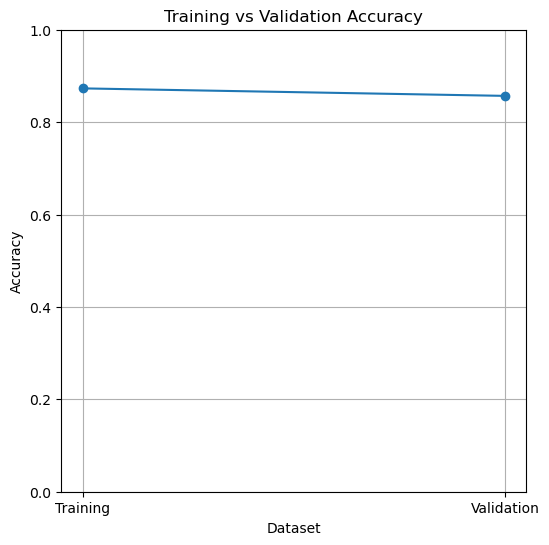

Test Accuracy: 0.845


In [64]:
best_alpha = max(alpha_results, key=lambda x: x[1])[0]
best_class_prior = max(class_prior_results, key=lambda x: x[1])[0] if max(class_prior_results, key=lambda x: x[1])[0] != 'None' else None

print(f"Best alpha: {best_alpha}")
print(f"Best class_prior: {best_class_prior}")

# Train the final model with the best hyperparameters on the entire training data
final_nb_classifier = MultinomialNB(alpha=best_alpha, fit_prior=False, class_prior=eval(best_class_prior) if best_class_prior != 'None' else None)
final_nb_classifier.fit(x_train, y_train)

# Evaluate the final model on the training data to compute training accuracy
train_accuracy = final_nb_classifier.score(x_train, y_train)

# Cross-validation to evaluate validation accuracy
val_accuracy = cross_val_score(final_nb_classifier, x_train, y_train, cv=5).mean()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [train_accuracy, val_accuracy], marker='o')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xticks([0, 1], ['Training', 'Validation'])
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Evaluate the final model on the test data
test_predictions = final_nb_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {round(test_accuracy, 3)}")